Bibliotecas

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import random as rand
import seaborn as sns
import pandas as pd
import math

Funciones para calcular y combinar las métricas de repetitividad y distinción de pares

In [ ]:
#Lee las funciones del fichero que recibe como parametro
def leeFunciones(nombreFichero):
    funciones = np.genfromtxt(nombreFichero, dtype = float, usecols=0, unpack=True)
    funcionesStr = np.genfromtxt(nombreFichero, dtype = str, usecols=1, unpack=True)
    return funciones, funcionesStr

#Recibe un valor entero y devuelve la cadena binaria asociada con 32 bits
def binario32(num):
    return '{:032b}'.format(int(num))

# Recibe un valor entero y devuelve la cadena binaria asociada con 5 bits
def binario5(num):
    return '{:05b}'.format(int(num))

# Genera tantas funciones complementarias a 'funciones' como le indique 'numero'
def generaComplementarias(numero):
    generados = 0
    funcComp = []
    while generados < numero:
        funcRand = rand.randint(0, 2**32-1)
        if funcRand not in funciones:
            funcComp.append(funcRand)
            generados += 1
    return funcComp

# Normaliza los valores del numpy array 'valores' con el minimo y máximo que la indiquen los otros parametros
def normaliza(valores, minimo, maximo):
    return (valores - minimo) /(maximo - minimo)

# Calcula la puntuacion de repetitividad dados los segmentos de la partición en un array
def puntuacionRepeticiones(segmentos):
    puntuacion = 0
    for elem in set(segmentos):
        apariciones = segmentos.count(elem)
        if apariciones > 1:
            puntuacion += apariciones*len(elem)
    return puntuacion

# Dada una cadena binaria la divide según la partición más fina y calcula su puntuaciónde repetitividad
def repetitividad(s):
    puntRepGlobal = 0
    posActual = 0
    segmentos = []
    for num in [4,4,4,4,4,4,4,4]:
        segmentos.append(s[posActual:posActual+num])
        posActual += num
    return puntuacionRepeticiones(segmentos)

# Calcula la puntuación de repetitividad de un array de cadenas y las devuelve en un numpy array
def calculaRepetitividades(funciones):
    return np.array([repetitividad(binario32(s)) for s in funciones])

#Dada una cadena de tamaño 32 devuelve la cantidad de valores que estan a '0'
def cerosFuncion(funcion):
    return [i for i in range(32) if funcion[i] == '0']

#Dada una cadena de tamaño 32 devuelve la cantidad de valores que estan a '1'
def unosFuncion(funcion):
    return [i for i in range(32) if funcion[i] == '1']

#Dadas dos cadenas calcula su foco y contexto y devuelve las posiciones de los focos
def diferenciaPar(par1,par2):
    diferencias1 = ""
    diferencias2 = ""
    contexto = ""
    posiciones = []
    for i in range(len(par1)):
        if par1[i] != par2[i]:
            diferencias1 += par1[i]
            diferencias2 += par2[i]
            posiciones.append(i)
        else:
            contexto += par1[i]
    return diferencias1, diferencias2, posiciones, contexto

# Devuelve la cantidad de caracteres en común entre 2 cadenas
def coincidencia(cad1,cad2):
    return sum(map(lambda x,y: x==y, cad1, cad2))

#Funcion que calcula la puntuación de distinción de pares cruzados para una cadena (con o sin mejoras en función de varios booleanos)
def puntuacionDistParesFuncion(funcion):
    saca0 = cerosFuncion(funcion)
    saca1 = unosFuncion(funcion)
    punt = 0
    distintosAlMenos2 = []
    for fun0 in saca0:
        for fun1 in saca1:
            par1 = fun0
            par2 = fun1
            dif1, dif2, pos, contexto = diferenciaPar(binario5(fun0),binario5(fun1))
            distintosAlMenos2.append((dif1,dif2,pos,par1,par2,contexto))
    cruces = 0
    for i in range(len(distintosAlMenos2)):
        dif1, dif2, pos, par1, par2, contexto = distintosAlMenos2[i]
        for j in range(i, len(distintosAlMenos2)):
            dif1bis, dif2bis, posbis, par1bis, par2bis, contextobis = distintosAlMenos2[j]
            if dif1 == dif2bis and dif2 == dif1bis and pos == posbis:
                    cruces += 5-len(dif1)
                    cruces += coincidencia(contexto,contextobis)/len(contexto)
    return cruces


# Función que calcula las puntuaciones de distinción de pares cruzados para un array de cadenas (con o sin mejoras en función de varios booleanos)
def puntuacionDistPares(funciones):
    return np.array([puntuacionDistParesFuncion(binario32(funcion)) for funcion in funciones])

# Genera pruebas para laas combinaciones con los valores de los parametros alpha y beta que recibe en 'parametros'
# con muestras de tamaño 'nMuestras' para las funciones dadas en 'funciones'
def pruebaCombinacionMetricasParam(nMuestra, funciones, parametros):
    # Muestras de entrenamiento
    muestraData = np.random.choice(funciones, nMuestra)
    muestraComp = generaComplementarias(nMuestra)

    puntParesData = puntuacionDistPares(muestraData)
    puntParesComp = puntuacionDistPares(muestraComp)
    
    # Normalización de los datos al intervalo común [0,1]
    minimo = min(np.min(puntParesData), np.min(puntParesComp))
    maximo = max(np.max(puntParesData), np.max(puntParesComp))
    puntParesDataNorm = normaliza(puntParesData, minimo, maximo)
    puntParesCompNorm = normaliza(puntParesComp, minimo, maximo)

    puntRepData = calculaRepetitividades(muestraData)
    puntRepComp = calculaRepetitividades(muestraComp)
    puntRepDataNorm = normaliza(puntRepData, 0, 32)
    puntRepCompNorm = normaliza(puntRepComp, 0, 32)

    plt.title("Funciones del dataset")
    plt.xlabel('Función')
    plt.ylabel('Puntuación reescalada')
    plt.scatter(muestraData, puntRepDataNorm, marker = 'x', color = 'blue', label = 'Puntuación repetitividad')
    plt.scatter(muestraData, puntParesDataNorm, marker = '.', color = 'red', label ='Puntuación diferenciación pares')
    plt.legend(loc = 'upper right')
    plt.savefig('puntuacionesCombEntrenoData.pdf')
    plt.show()

    plt.title("Funciones del complementario")
    plt.xlabel('Función')
    plt.ylabel('Puntuación reescalada')
    plt.scatter(muestraComp, puntRepCompNorm, marker = 'x', color = 'blue', label = 'Puntuación repetitividad')
    plt.scatter(muestraComp, puntParesCompNorm, marker = '.', color = 'red', label ='Puntuación diferenciación pares')
    plt.legend(loc = 'upper right')
    plt.savefig('puntuacionesCombEntrenoComp.pdf')
    plt.show()

    for alpha, beta in parametros:
            # Calculo de la combinacion de puntuaciones
            puntDataComb = alpha * puntRepDataNorm + beta * puntParesDataNorm
            puntCompComb = alpha * puntRepCompNorm + beta * puntParesCompNorm
            # Normalizacion de la combinación
            puntDataCombNorm = normaliza(puntDataComb, beta, alpha)
            puntCompCombNorm = normaliza(puntCompComb, beta, alpha)
            # Histograma de puntuaciones
            plt.figure(1)
            plt.hist(puntDataCombNorm, bins='auto', alpha = 0.5, label='dataset')
            plt.hist(puntCompCombNorm, bins='auto', alpha = 0.5, label='complementario')
            plt.title('Puntuaciones de la combinación con alpha = {} y beta = {} normalizadas'.format(alpha,beta))
            plt.xlabel("Puntuación")
            plt.ylabel("Nº veces con esa puntuacion")
            plt.savefig('distribucionCombinacion{}{}.pdf'.format(alpha,beta))
            plt.show()
            # Test de acierto
            muestraDataTest = np.random.choice(funciones, nMuestra)
            muestraCompTest = generaComplementarias(nMuestra)
            puntParesDataTest = puntuacionDistPares(muestraDataTest)
            puntParesCompTest = puntuacionDistPares(muestraCompTest)
            puntParesDataTestNorm = normaliza(puntParesDataTest, minimo, maximo)
            puntParesCompTestNorm = normaliza(puntParesCompTest, minimo, maximo)
            puntRepDataTest = calculaRepetitividades(muestraDataTest)
            puntRepCompTest = calculaRepetitividades(muestraCompTest)
            puntRepDataNormTest = normaliza(puntRepDataTest, 0, 32)
            puntRepCompNormTest = normaliza(puntRepCompTest, 0, 32)
            puntDataCombTest = alpha * puntRepDataNorm + beta * puntParesDataNorm
            puntCompCombTest = alpha * puntRepCompNorm + beta * puntParesCompNorm
            puntDataCombTestNorm = normaliza(puntDataCombTest, beta, alpha)
            puntCompCombTestNorm = normaliza(puntCompCombTest, beta, alpha)
            mediaData = np.mean(puntDataCombNorm)
            mediaComp = np.mean(puntCompCombNorm)
            aciertoData = np.sum(np.abs(puntDataCombTestNorm - mediaData) <= np.abs(puntDataCombTestNorm - mediaComp))/nMuestra
            aciertoComp = np.sum(np.abs(puntCompCombTestNorm - mediaComp) <= np.abs(puntCompCombTestNorm - mediaData))/nMuestra
            print('Con alpha = {} y beta = {}, acierto del dataset: {} %, acierto del complementario: {} %'.format(alpha,beta,aciertoData*100, aciertoComp*100))


Cargamos los datos

In [ ]:
funciones,_  = leeFunciones('/content/drive/MyDrive/TFG/funcionesSinRepeticion.txt')

Hacemos pruebas con varios valores para los parametros $\alpha$ y $\beta$ en distintas proporciones

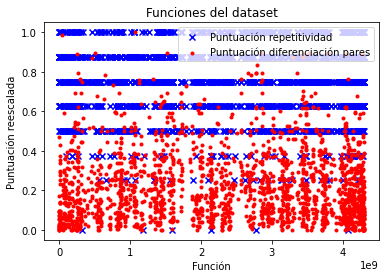

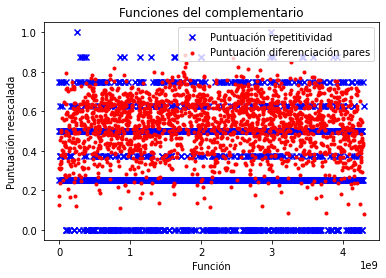

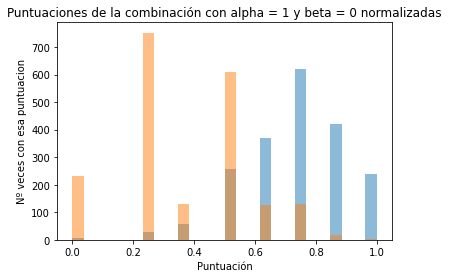

Con alpha = 1 y beta = 0, acierto del dataset: 82.69999999999999 %, acierto del complementario: 86.15 %


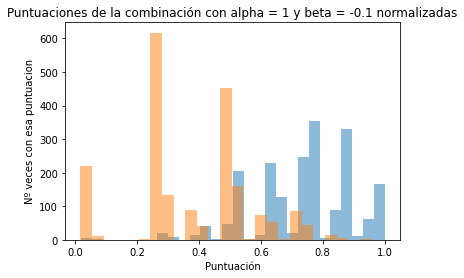

Con alpha = 1 y beta = -0.1, acierto del dataset: 82.69999999999999 %, acierto del complementario: 86.15 %


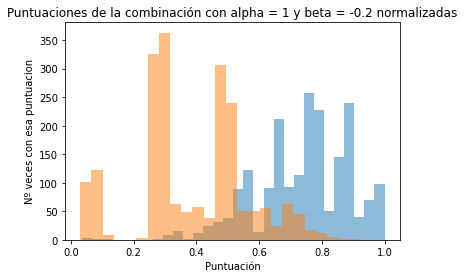

Con alpha = 1 y beta = -0.2, acierto del dataset: 85.55 %, acierto del complementario: 86.1 %


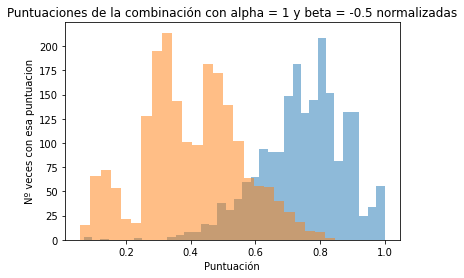

Con alpha = 1 y beta = -0.5, acierto del dataset: 89.8 %, acierto del complementario: 87.3 %


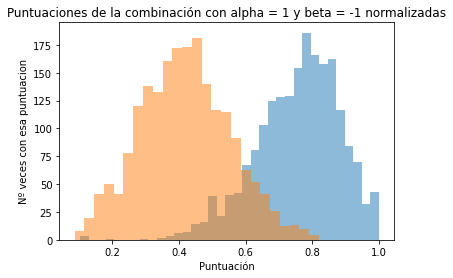

Con alpha = 1 y beta = -1, acierto del dataset: 90.35 %, acierto del complementario: 89.1 %


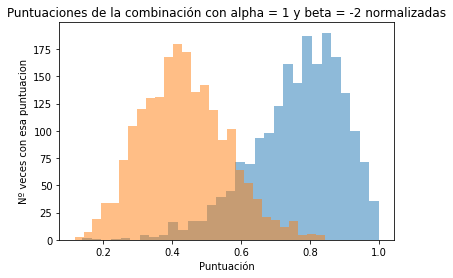

Con alpha = 1 y beta = -2, acierto del dataset: 88.4 %, acierto del complementario: 90.10000000000001 %


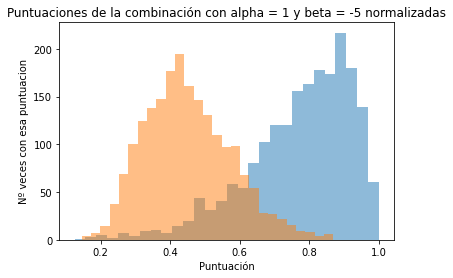

Con alpha = 1 y beta = -5, acierto del dataset: 85.65 %, acierto del complementario: 89.4 %


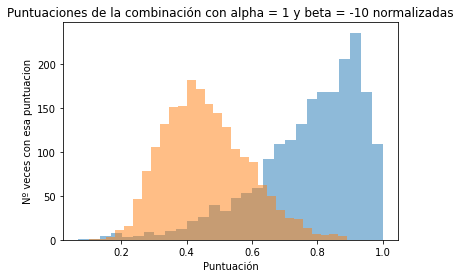

Con alpha = 1 y beta = -10, acierto del dataset: 84.65 %, acierto del complementario: 88.3 %


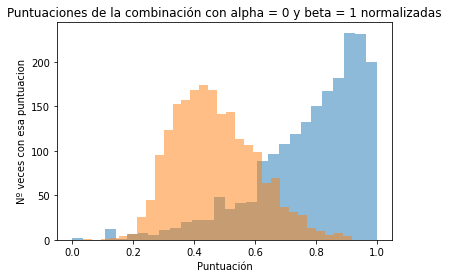

Con alpha = 0 y beta = 1, acierto del dataset: 82.89999999999999 %, acierto del complementario: 86.6 %


In [ ]:
parametros = [(1,0),(1,-0.1),(1,-0.2),(1,-0.5),(1,-1),(1,-2),(1,-5),(1,-10), (0,1)]
pruebaCombinacionMetricasParam(2000, funciones, parametros)